In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import classification_report, recall_score, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Loan_Default_Prediction_Analysis.csv")
data.head()


,LoanID,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education,EmploymentType,MaritalStatus,HasMortgage,HasDependents,LoanPurpose,HasCoSigner,Default
0,I38PQUQS96,56,85994,50587,520,80,4,15.23,36,0.44,Bachelor's,Full-time,Divorced,Yes,Yes,Other,Yes,0
1,HPSK72WA7R,69,50432,124440,458,15,1,4.81,60,0.68,Master's,Full-time,Married,No,No,Other,Yes,0
2,C1OZ6DPJ8Y,46,84208,129188,451,26,3,21.17,24,0.31,Master's,Unemployed,Divorced,Yes,Yes,Auto,No,1
3,V2KKSFM3UN,32,31713,44799,743,0,3,7.07,24,0.23,High School,Full-time,Married,No,No,Business,No,0
4,EY08JDHTZP,60,20437,9139,633,8,4,6.51,48,0.73,Bachelor's,Unemployed,Divorced,No,Yes,Auto,No,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255347 entries, 0 to 255346
Data columns (total 18 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   LoanID          255347 non-null  object 
 1   Age             255347 non-null  int64  
 2   Income          255347 non-null  int64  
 3   LoanAmount      255347 non-null  int64  
 4   CreditScore     255347 non-null  int64  
 5   MonthsEmployed  255347 non-null  int64  
 6   NumCreditLines  255347 non-null  int64  
 7   InterestRate    255347 non-null  float64
 8   LoanTerm        255347 non-null  int64  
 9   DTIRatio        255347 non-null  float64
 10  Education       255347 non-null  object 
 11  EmploymentType  255347 non-null  object 
 12  MaritalStatus   255347 non-null  object 
 13  HasMortgage     255347 non-null  object 
 14  HasDependents   255347 non-null  object 
 15  LoanPurpose     255347 non-null  object 
 16  HasCoSigner     255347 non-null  object 
 17  Default   

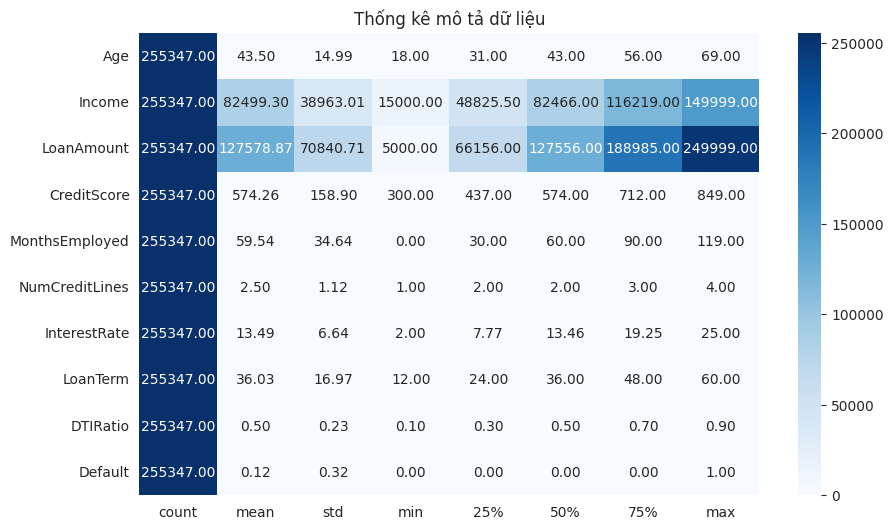

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
desc = data.describe().T   # transpose để dễ nhìn

plt.figure(figsize=(10,6))
sns.heatmap(desc, annot=True, cmap="Blues", fmt=".2f")
plt.title("Thống kê mô tả dữ liệu")
plt.show()

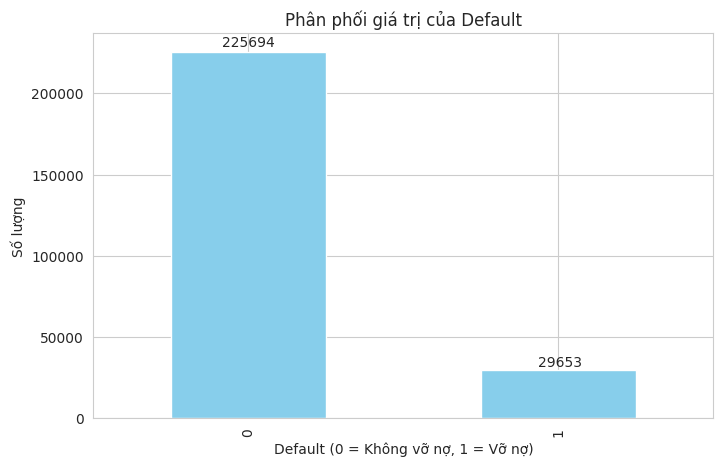

In [ ]:
default_counts = data['Default'].value_counts()

plt.figure(figsize=(8, 5))
ax = default_counts.plot(kind="bar", color=["skyblue","skyblue"])
plt.title("Phân phối giá trị của Default")
plt.xlabel("Default (0 = Không vỡ nợ, 1 = Vỡ nợ)")
plt.ylabel("Số lượng")

for p in ax.patches:
    ax.annotate(str(p.get_height()),
                (p.get_x() * 1.005 + p.get_width() / 2,
                 p.get_height() * 1.005),
                ha='center',
                va='bottom')

plt.show()

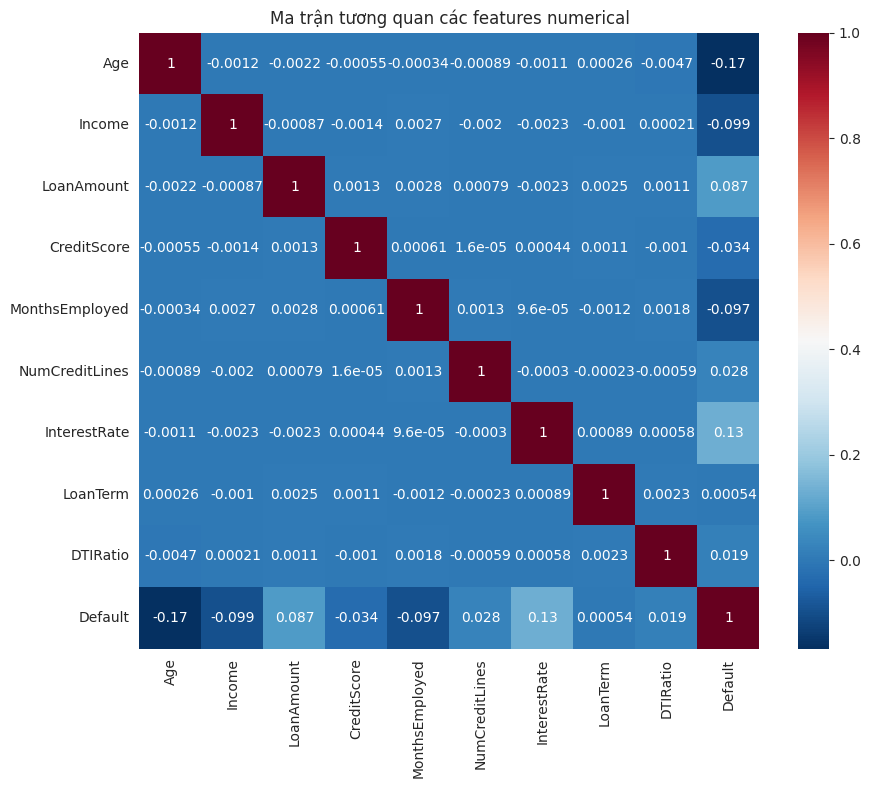

In [ ]:
numeric_cols = ['Age', 'Income', 'LoanAmount', 'CreditScore', 'MonthsEmployed', 'NumCreditLines', 'InterestRate', 'LoanTerm', 'DTIRatio', 'Default']
corr = data[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='RdBu_r')
plt.title('Ma trận tương quan các features numerical')
plt.show()

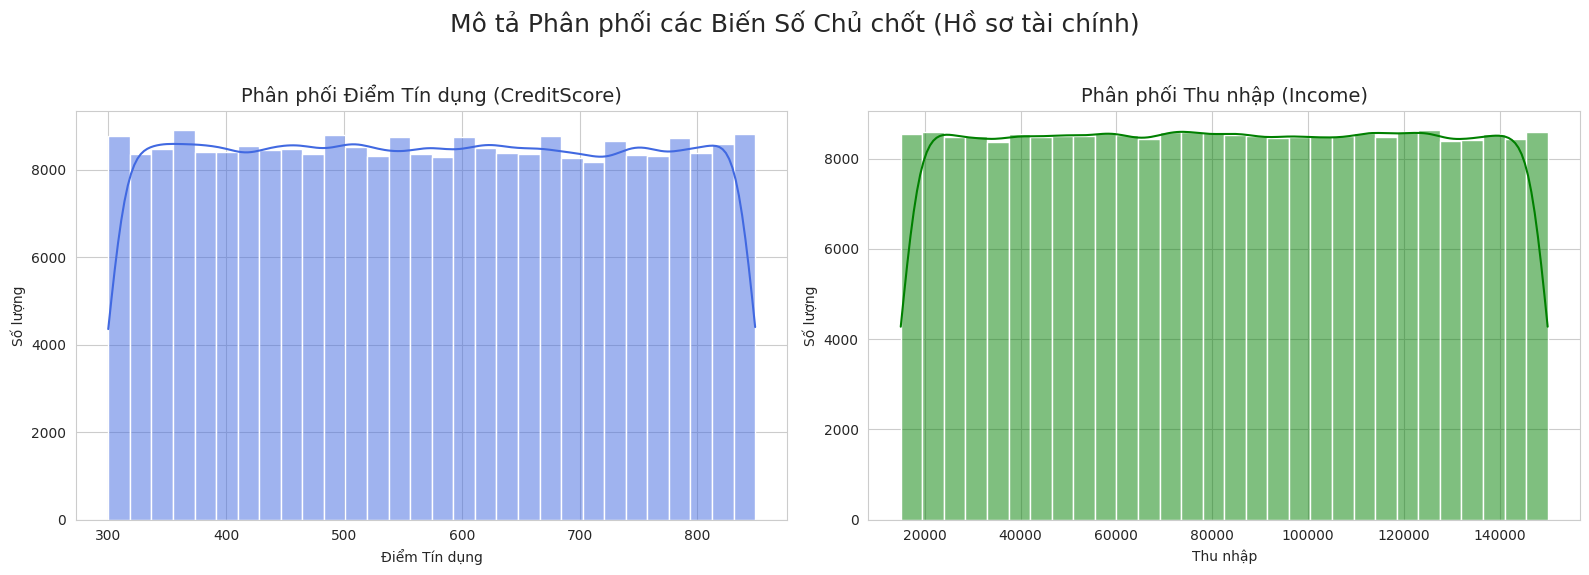

In [ ]:
sns.set_style('whitegrid')

# Chọn 2 cột số "chủ chốt"
cols_to_plot_num = ['CreditScore', 'Income']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Mô tả Phân phối các Biến Số Chủ chốt (Hồ sơ tài chính)', fontsize=18)

# 1. CreditScore
sns.histplot(data['CreditScore'], ax=axes[0], kde=True, bins=30, color='royalblue')
axes[0].set_title('Phân phối Điểm Tín dụng (CreditScore)', fontsize=14)
axes[0].set_xlabel('Điểm Tín dụng')
axes[0].set_ylabel('Số lượng')

# 2. Income
sns.histplot(data['Income'], ax=axes[1], kde=True, bins=30, color='green')
axes[1].set_title('Phân phối Thu nhập (Income)', fontsize=14)
axes[1].set_xlabel('Thu nhập')
axes[1].set_ylabel('Số lượng')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/tmp/ipython-input-1700597030.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0], data=data, x='LoanPurpose',
/tmp/ipython-input-1700597030.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[1], data=data, x='EmploymentType',


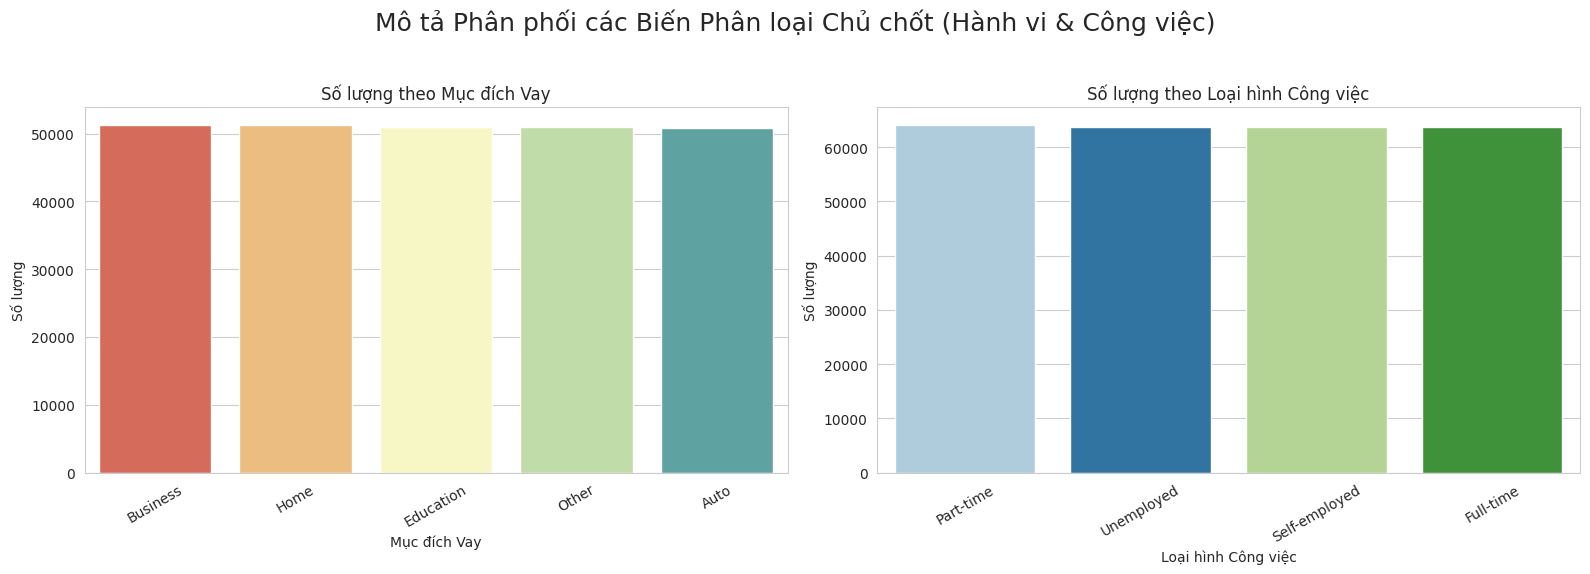

In [ ]:
cols_to_plot_cat = ['LoanPurpose', 'EmploymentType']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Mô tả Phân phối các Biến Phân loại Chủ chốt (Hành vi & Công việc)', fontsize=18)

# 1. LoanPurpose
sns.countplot(ax=axes[0], data=data, x='LoanPurpose',
              order=data['LoanPurpose'].value_counts().index, palette='Spectral')
axes[0].set_title('Số lượng theo Mục đích Vay')
axes[0].tick_params(axis='x', rotation=30)
axes[0].set_xlabel('Mục đích Vay')
axes[0].set_ylabel('Số lượng')

# 2. EmploymentType
sns.countplot(ax=axes[1], data=data, x='EmploymentType',
              order=data['EmploymentType'].value_counts().index, palette='Paired')
axes[1].set_title('Số lượng theo Loại hình Công việc')
axes[1].tick_params(axis='x', rotation=30)
axes[1].set_xlabel('Loại hình Công việc')
axes[1].set_ylabel('Số lượng')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

/tmp/ipython-input-674007750.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Default', y=col, palette=['skyblue', 'salmon'])
/tmp/ipython-input-674007750.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Default', y=col, palette=['skyblue', 'salmon'])
/tmp/ipython-input-674007750.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[row, col_idx], data=data, x='Default', y=col, palette=['skyblue', 'salmon'])
/tmp/ipython-input-674007750.py:9: FutureWarning:

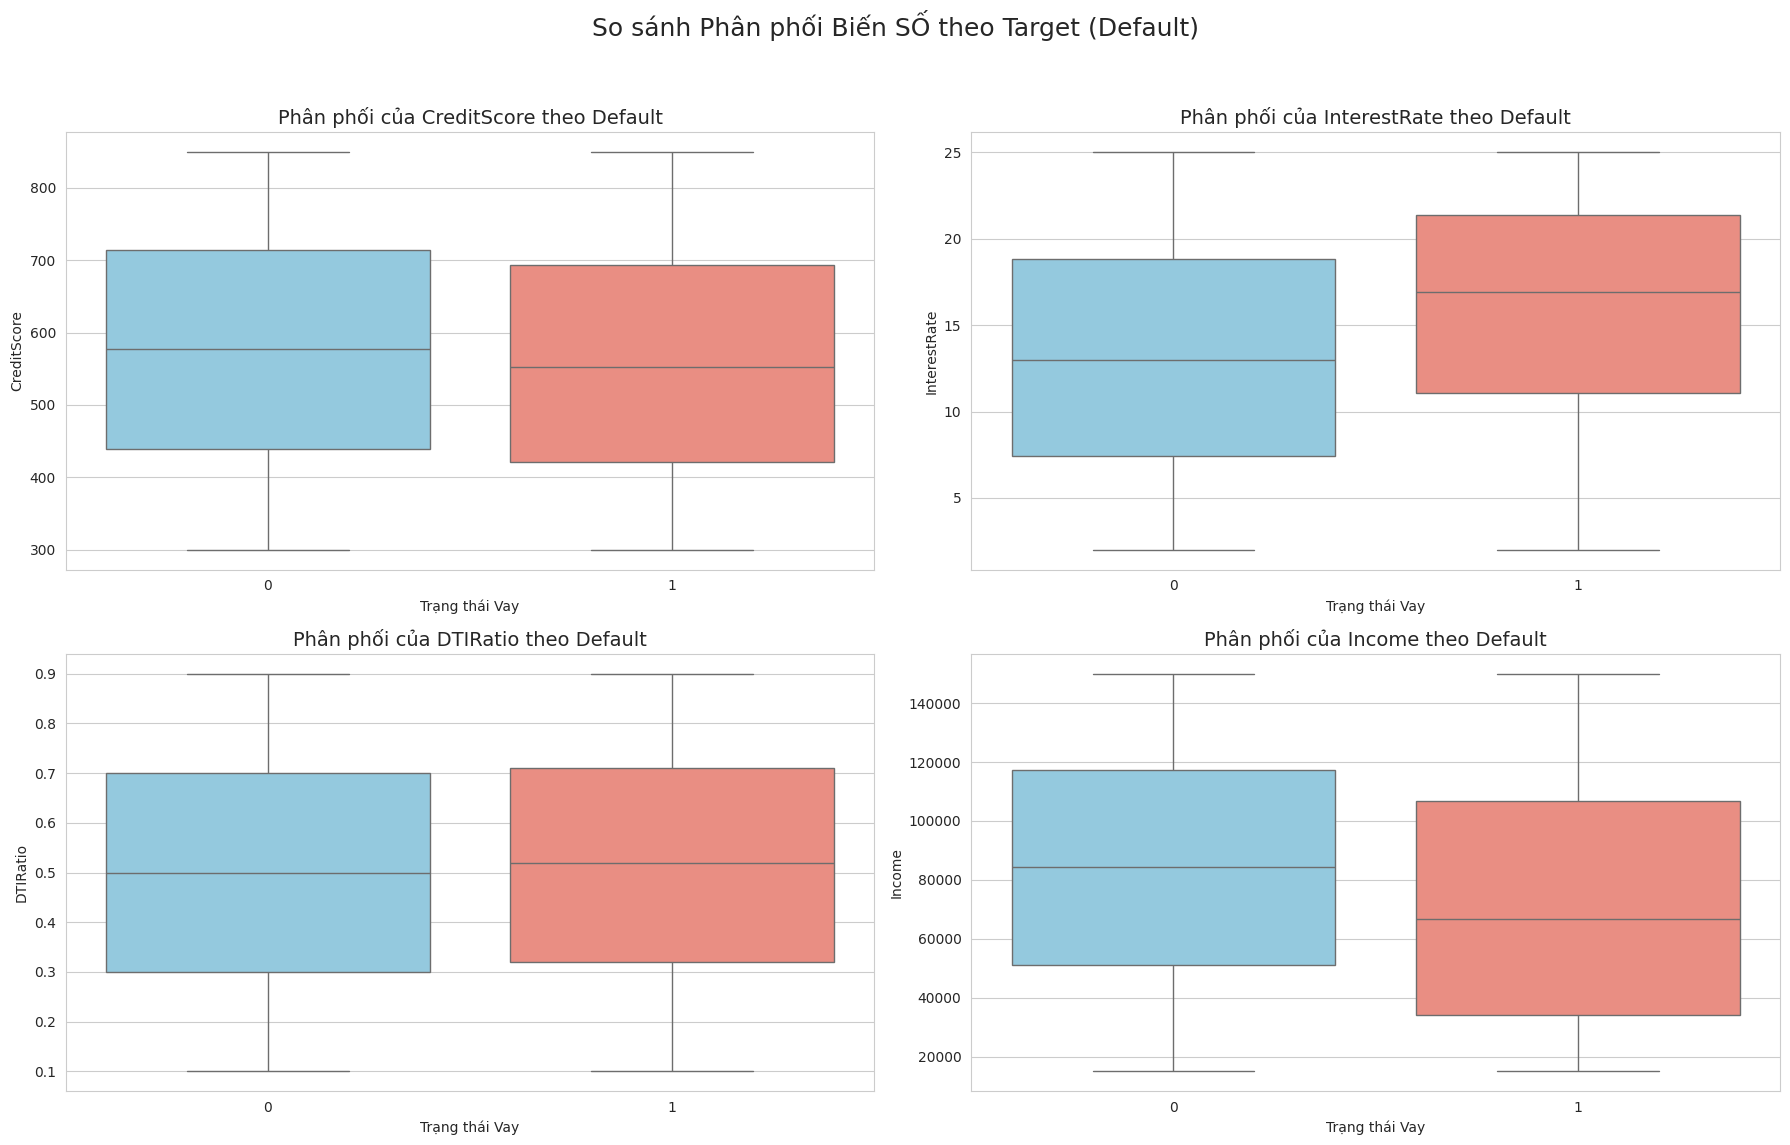

In [ ]:
important_num_cols = ['CreditScore', 'InterestRate', 'DTIRatio', 'Income']

fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('So sánh Phân phối Biến SỐ theo Target (Default)', fontsize=18)

for i, col in enumerate(important_num_cols):
    row = i // 2
    col_idx = i % 2
    sns.boxplot(ax=axes[row, col_idx], data=data, x='Default', y=col, palette=['skyblue', 'salmon'])
    axes[row, col_idx].set_title(f'Phân phối của {col} theo Default', fontsize=14)
    axes[row, col_idx].set_xlabel('Trạng thái Vay')
    axes[row, col_idx].set_ylabel(col)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

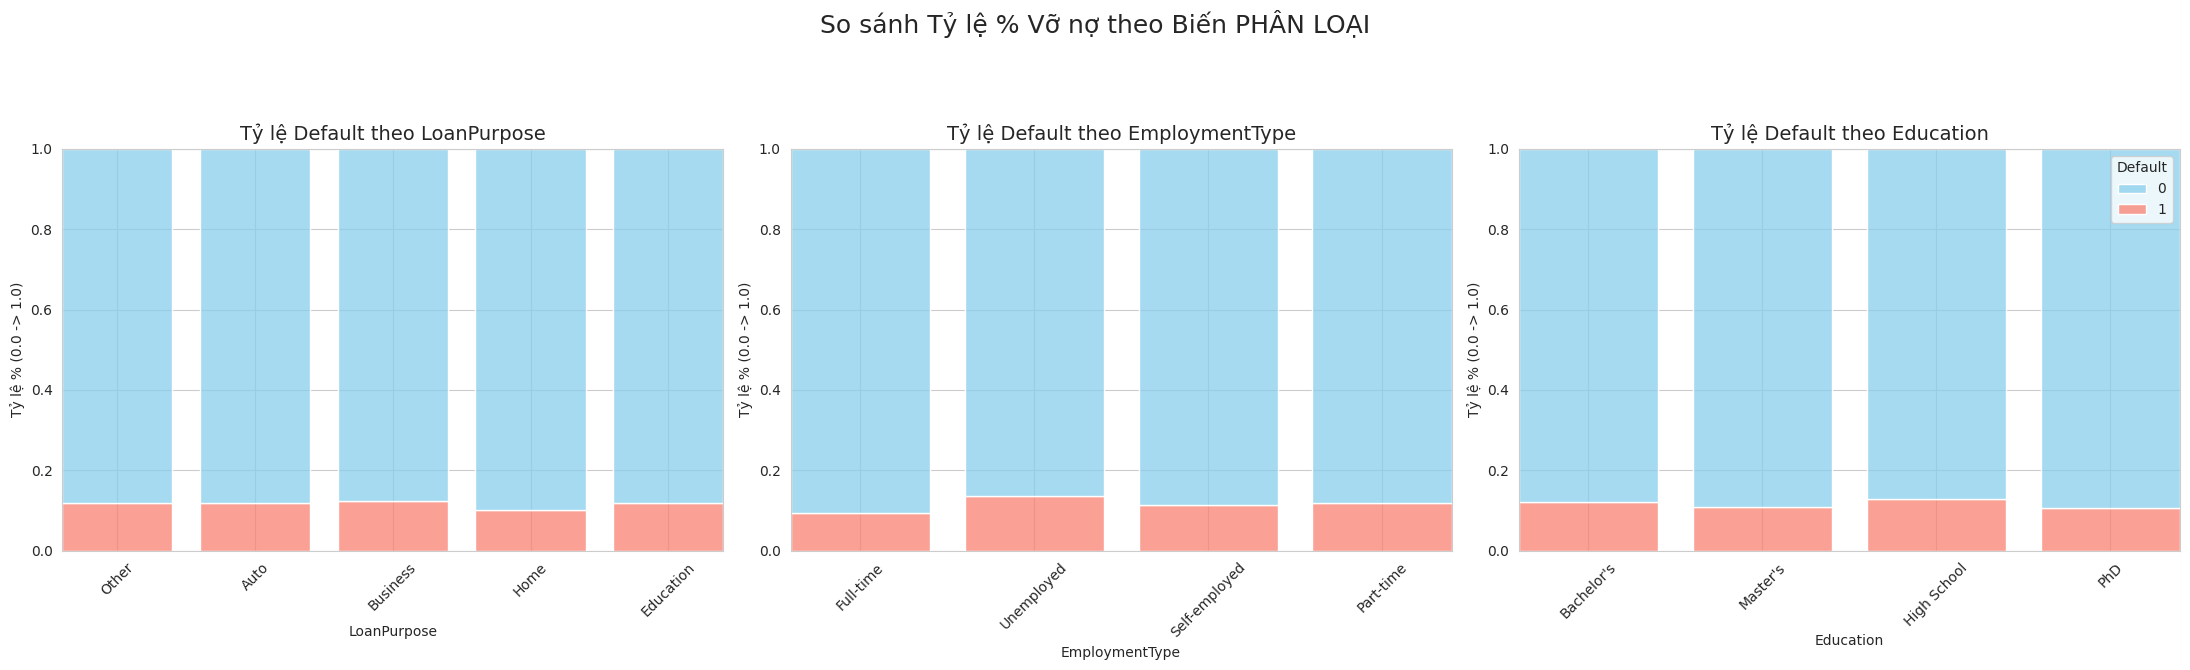

In [ ]:
important_cat_cols = ['LoanPurpose', 'EmploymentType', 'Education']

fig, axes = plt.subplots(1, 3, figsize=(22, 7))
fig.suptitle('So sánh Tỷ lệ % Vỡ nợ theo Biến PHÂN LOẠI', fontsize=18)

for i, col in enumerate(important_cat_cols):
    sns.histplot(data, x=col, hue='Default', multiple='fill', shrink=0.8, ax=axes[i], palette=['skyblue', 'salmon'])
    axes[i].set_title(f'Tỷ lệ Default theo {col}', fontsize=14)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_ylabel("Tỷ lệ % (0.0 -> 1.0)")

    if i < 2:
        axes[i].get_legend().remove()

plt.tight_layout(rect=[0, 0.03, 1, 0.9])
plt.show()

In [ ]:
target = "Default"
x = data.drop(columns=["LoanID", target], axis=1)
y = data[target]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [ ]:
ros = RandomOverSampler(random_state=0)
x_train, y_train = ros.fit_resample(x_train, y_train)

In [ ]:
numeric_features = ["Age", "Income", "LoanAmount", "CreditScore", "MonthsEmployed",
                    "NumCreditLines", "InterestRate", "LoanTerm", "DTIRatio"]

education_values = ["High School", "Bachelor's", "Master's", "PhD"]
employment_type_values = ["Unemployed", "Self-employed", "Part-time", "Full-time"]
HasMortgage_values = ["No", "Yes"]
HasDependents_values = ["No", "Yes"]
HasCoSigner_values = ["No", "Yes"]

ordinal_transformer = Pipeline(steps=[
    ("encoder", OrdinalEncoder(categories=[education_values,
                                           employment_type_values,
                                           HasMortgage_values,
                                           HasDependents_values,
                                           HasCoSigner_values]))
])


In [ ]:
preprocessor = ColumnTransformer(transformers=[
    ("num_feature", StandardScaler(), numeric_features),
    ("ord_feature", ordinal_transformer, ["Education", "EmploymentType", "HasMortgage", "HasDependents", "HasCoSigner"]),
    ("nom_feature", OneHotEncoder(), ["MaritalStatus", "LoanPurpose"])
])


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:07:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


🔹 XGBoost
              precision    recall  f1-score   support

           0       0.94      0.70      0.80     45170
           1       0.23      0.68      0.34      5900

    accuracy                           0.70     51070
   macro avg       0.59      0.69      0.57     51070
weighted avg       0.86      0.70      0.75     51070

ROC-AUC: 0.757

Confusion Matrix:
[[31706 13464]
 [ 1911  3989]]


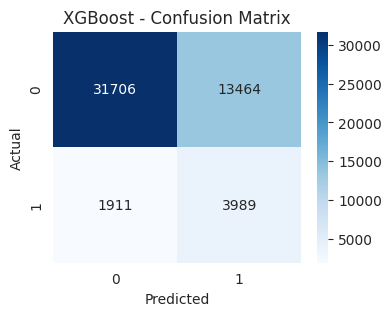

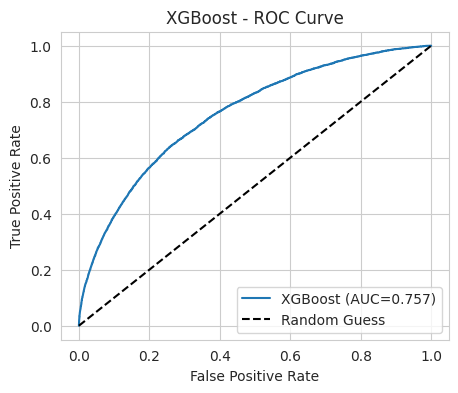

🔹 Random Forest
              precision    recall  f1-score   support

           0       0.94      0.69      0.79     45170
           1       0.22      0.68      0.33      5900

    accuracy                           0.68     51070
   macro avg       0.58      0.68      0.56     51070
weighted avg       0.86      0.68      0.74     51070

ROC-AUC: 0.747

Confusion Matrix:
[[30970 14200]
 [ 1901  3999]]


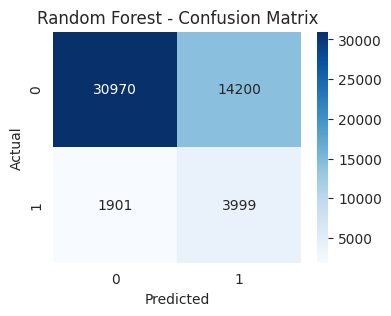

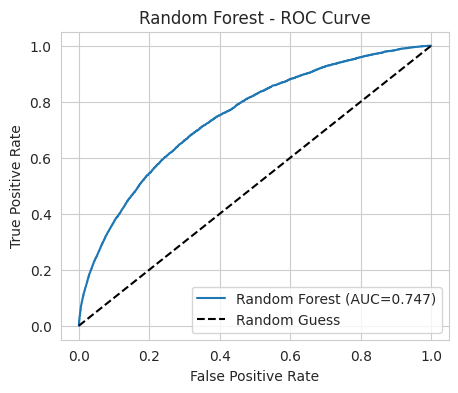

🔹 Logistic Regression
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     45170
           1       0.22      0.70      0.33      5900

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0.74     51070

ROC-AUC: 0.752

Confusion Matrix:
[[30534 14636]
 [ 1798  4102]]


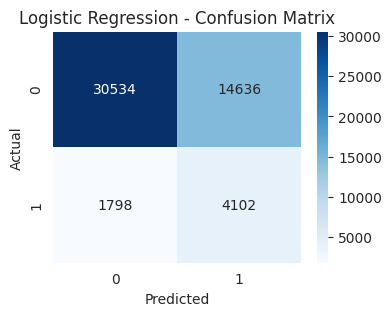

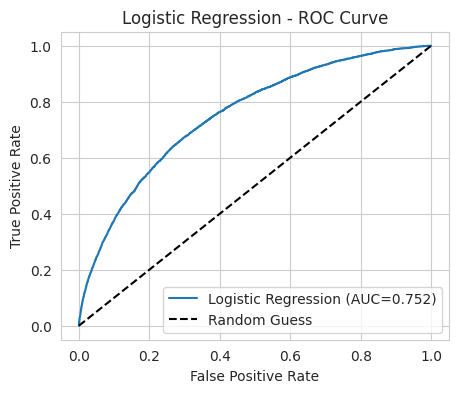

🔹 Decision Tree
              precision    recall  f1-score   support

           0       0.94      0.68      0.78     45170
           1       0.21      0.66      0.32      5900

    accuracy                           0.67     51070
   macro avg       0.57      0.67      0.55     51070
weighted avg       0.85      0.67      0.73     51070

ROC-AUC: 0.724

Confusion Matrix:
[[30493 14677]
 [ 2032  3868]]


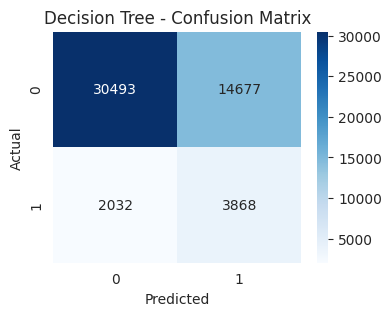

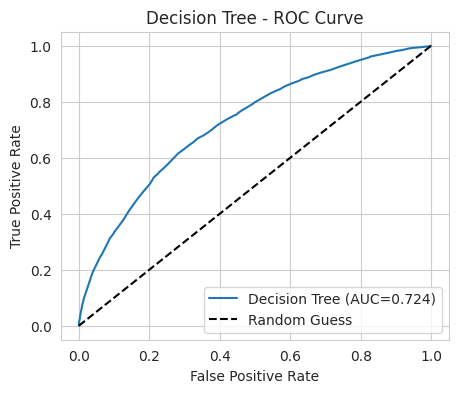

🔹 SVM
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     45170
           1       0.22      0.70      0.33      5900

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0.74     51070

ROC-AUC: 0.752

Confusion Matrix:
[[30525 14645]
 [ 1798  4102]]


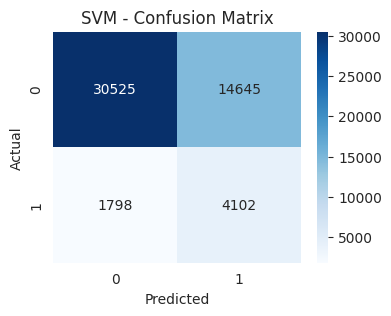

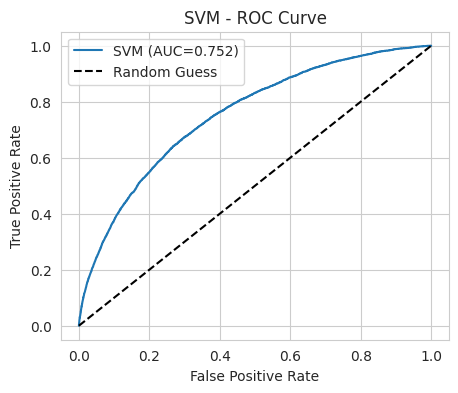

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

models = {
    "XGBoost": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        scale_pos_weight=sum(y_train==0)/sum(y_train==1),
        subsample=0.8,
        colsample_bytree=0.8
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=100,
        max_depth=7,
        class_weight='balanced'
    ),
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='liblinear'
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=7,
        class_weight='balanced'
    ),
    "SVM": CalibratedClassifierCV(
        LinearSVC(
            class_weight='balanced',
            max_iter=5000,
            random_state=42
        ),
        cv=3  # 3-fold cross-validation để hiệu chỉnh xác suất
    )
}

results = {}

for name, model in models.items():
    reg = ImbPipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    reg.fit(x_train, y_train)
    pred = reg.predict(x_test)

    if hasattr(reg, "predict_proba"):
        prob = reg.predict_proba(x_test)[:, 1]
        auc = roc_auc_score(y_test, prob)
    else:
        prob = None
        auc = float('nan')

    recall = recall_score(y_test, pred, average='macro')
    cm = confusion_matrix(y_test, pred)

    # Lưu kết quả
    results[name] = {
        "Recall": recall,
        "ROC_AUC": auc
    }


    print("="*70)
    print(f"🔹 {name}")
    print(classification_report(y_test, pred))
    print(f"ROC-AUC: {auc:.3f}")
    print("\nConfusion Matrix:")
    print(cm)

    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


    if prob is not None:
        fpr, tpr, _ = roc_curve(y_test, prob)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"{name} - ROC Curve")
        plt.legend()
        plt.show()


In [ ]:
import joblib

logistic_model = models["Logistic Regression"]

final_pipeline = ImbPipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", logistic_model)
])

print("Bắt đầu huấn luyện pipeline Logistic Regression...")
final_pipeline.fit(x_train, y_train)
print("Đã huấn luyện xong!")

joblib.dump(final_pipeline, 'credit_risk_pipeline.pkl')

print("Đã lưu pipeline (preprocessor + model) vào tệp 'credit_risk_pipeline.pkl'")

y_pred_final = final_pipeline.predict(x_test)
print("\n--- Báo cáo trên tập Test ---")
print(classification_report(y_test, y_pred_final))

Bắt đầu huấn luyện pipeline Logistic Regression...
Đã huấn luyện xong!
Đã lưu pipeline (preprocessor + model) vào tệp 'credit_risk_pipeline.pkl'

--- Báo cáo trên tập Test ---
              precision    recall  f1-score   support

           0       0.94      0.68      0.79     45170
           1       0.22      0.70      0.33      5900

    accuracy                           0.68     51070
   macro avg       0.58      0.69      0.56     51070
weighted avg       0.86      0.68      0.74     51070

